# How to use QRydDemo's emulator with Qoqo?

Accessing the QRydDemo's emulator with Qoqo is supported by the QRydHQS software packages [qoqo-qryd](https://github.com/HQSquantumsimulations/qoqo_qryd). The QRydHQS software is designed to enable the excution of quantum algorithms implemented in [qoqo](<https://github.com/HQSquantumsimulations/qoqo>) on Qryd hardware. Qoqo is a circuit based quantum computing toolkit. Like many other quantum computing toolkits it can be used to construct quantum circuits sequences of quantum operations that are to be executed on a quantum computer.

`qoqo` can be installed via the Python package manager pip
```bash
> pip install qoqo
```

For the python package `qoqo-qryd` we recommend checking out the latest tagged version from github installing it via pip.  
```bash
> pip install qoqo-qryd
```


In the following, we demonstrate how users can compile arbitrary quantum algorithms to the gate set and connectivities supported by our backends, using the example of a quantum Fourier transform. We then show how compiled algorithms can be executed on our cloud emulator.

<font color='red'>*You can adapt and execute this notebook to run your own calculations on our servers (Menu Bar > Run > Run All Cells), without having to install the qoqo-qryd. However, the notebook will be reset at 00:00 CET/CEST and all your changes will be lost. Thus, please make sure to download your notebook and save it locally.*</font>

**Currently supported Rydberg gates:**
* Phase shift of the qubit state |1>    (`PhaseShiftState1`)
* Rotation around an arbitrary axis in the xy-plane (`RotateXY`)
* Phase-shifted CZ-gate (a Rydberg variant of the CZ-gate \[[1](https://doi.org/10.1103/PhysRevLett.123.170503), [2](https://arxiv.org/abs/2202.13849)\]) (`PhaseShiftedControlledZ`)

**Currently supported connectivities:**
<table align=left><tr>
<td> <img src="square.png" alt="Square lattice with nearest-neighbor connectivity" style="width: 300px;"/> </td>
<td> <img src="triangle.png" alt="Triangle lattice with nearest-neighbor connectivity" style="width: 300px;"/> </td>
</tr></table>

## 1. Basic usage

### Initialize the QRydDemo access

To initialize the access, a QRydDemo API token is required. The token can be obtained via the registration form at [thequantumlaend.de](https://thequantumlaend.de/frontend/signup_form.php).
For convenience, your token has already been loaded into this notebook.

In [57]:
import os
token = os.getenv("QRYD_API_TOKEN")

### Choose a backend

Different devices are available for the API backend that are capable of running ideal simulations of quantum circuits. An inclusion of noise models is planned for the future. You can either choose a device emulating 30 qubits arranged in a 5x6 square lattice with nearest-neighbor connectivity `QrydEmuSquareDevice` or in a triangle lattice `QrydEmuTriangularDevice`. 

The QRyd compiler - a decomposer developed by [HQS Quantum Simulations](https://quantumsimulations.de/) - automatically transpiles arbitrary quantum circuits to comply with the native gate set and connectivity of the Rydberg platform when running the devices on the QRyd servers.

In [58]:
from qoqo_qryd import APIBackend
from qoqo_qryd.api_devices import QrydEmuTriangularDevice
import numpy as np

device = QrydEmuTriangularDevice(seed=1, pcz_theta=np.pi)
backend = APIBackend(device=device, access_token=token, timeout=30) # timeout in seconds, 30s per default

### Create a quantum algorithm

You can use the gate operations provided by Qoqo to create a quantum algorithm, e.g., in the following, we create a quantum circuit that calculates the Fourier transform of a rectangular function.

In [59]:
from qoqo import Circuit
from qoqo import operations as ops
import numpy as np

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit += ops.Hadamard(qubit=n)
    for qubit in range(n):
        circuit += ops.ControlledPhaseShift(control=qubit, target=n, theta=np.pi/2**(n-qubit))
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    """Performs the swap part of the QFT algorithm"""
    for qubit in range(n//2):
        circuit += ops.SWAP(control=qubit, target=n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Create a quantum circuit object
num_qubits = 4
qc = Circuit()
# add a register to store the measurement to the Circuit
qc += ops.DefinitionBit(name='ro', length=num_qubits, is_output=True)

# Encode the state |0>+|1>+|2>+|3>=|0000>+|0001>+|0010>+|0011> (i.e. a state that corresponds
# to a rectangular function in the context of the qft), apply the qft, and measure all qubits
qc += ops.Hadamard(0)
qc += ops.Hadamard(1)
qft(qc,num_qubits)
# add a measurement operation to the Circuit, here a PragmaRepeatedMeasurement operation valid on QRyd emulators
qc += ops.PragmaRepeatedMeasurement(readout='ro', number_measurements=2**18)

# Print the resulting quantum circuit
print(qc)

DefinitionBit(DefinitionBit { name: "ro", length: 4, is_output: true })
Hadamard(Hadamard { qubit: 0 })
Hadamard(Hadamard { qubit: 1 })
Hadamard(Hadamard { qubit: 3 })
ControlledPhaseShift(ControlledPhaseShift { control: 0, target: 3, theta: Float(0.39269908169872414) })
ControlledPhaseShift(ControlledPhaseShift { control: 1, target: 3, theta: Float(0.7853981633974483) })
ControlledPhaseShift(ControlledPhaseShift { control: 2, target: 3, theta: Float(1.5707963267948966) })
Hadamard(Hadamard { qubit: 2 })
ControlledPhaseShift(ControlledPhaseShift { control: 0, target: 2, theta: Float(0.7853981633974483) })
ControlledPhaseShift(ControlledPhaseShift { control: 1, target: 2, theta: Float(1.5707963267948966) })
Hadamard(Hadamard { qubit: 1 })
ControlledPhaseShift(ControlledPhaseShift { control: 0, target: 1, theta: Float(1.5707963267948966) })
Hadamard(Hadamard { qubit: 0 })
SWAP(SWAP { control: 0, target: 3 })
SWAP(SWAP { control: 1, target: 2 })
PragmaRepeatedMeasurement(PragmaRepeatedMea

### Run the circuit on the emulator

You can execute a circuit that will be automatically compiled on our cloud emulator by running `backend.run_circuit(qc)`. Alternatively, you can create and run a QuantumProgram by `program.run(backend)`.

In [60]:
from qoqo.measurements import ClassicalRegister
from qoqo import QuantumProgram
from time import sleep

# Alternativ 1: Run the circuit (unused in this example)
(result_bit_registers, result_float_registers, result_complex_registers) = backend.run_circuit(qc)

# Alternativ 2: Run the program (followed up in this example)
measurement = ClassicalRegister(circuits=[qc], constant_circuit=None)
program = QuantumProgram(measurement=measurement, input_parameter_names=[]) # no free parameters allowed on the QRyd emulators
job = backend.post_job(program)

# wait
sleep(10)

# get job status and result
job_status = backend.get_job_status(job)
print("Job status: ", job_status['status'])
if job_status["status"] == "completed":
    result = backend.get_job_result(job)
    print(f"Execution time: {result['time_taken']:.4f} s")

test


[roqoqo-qryd/src/api_backend.rs:597] &status = ""


Job status:  completed
Execution time: 0.0207 s


<BarContainer object of 13 artists>

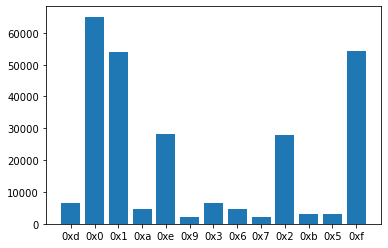

In [61]:
# Plot the results
import matplotlib.pyplot as plt

counts = result['data']['counts']
plt.bar(counts.keys(), counts.values())

Details on the job result object can be accessed by the key words, for example:

In [62]:
print(f"Number of executed single-qubit gates: {result['executed_single_qubit_gates']}")
print(f"Number of executed two-qubit gates: {result['executed_two_qubit_gates']}")
print(f"Number of gates after gate fusion: {result['fusion_generated_gates']}")

Number of executed single-qubit gates: 702
Number of executed two-qubit gates: 102
Number of gates after gate fusion: 1
